# Preparing Datasets
fetching train, val, test datasets from GitHub Repo https://github.com/KhalidSinan/QbMS-Model/tree/main/datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
chunks = 7
train_ds = pd.DataFrame()
for i in range(chunks):
  chunk = pd.read_parquet(f'https://raw.githubusercontent.com/KhalidSinan/QbMS-Model/main/datasets/train/train_chunk_{i+1}.parquet', engine="pyarrow")
  train_ds = pd.concat([train_ds, chunk], ignore_index=True, axis=0)
  print(f"{i+1} Chunk Loaded Successfully with", len(chunk), " records")

1 Chunk Loaded Successfully with 1000  records
2 Chunk Loaded Successfully with 1000  records
3 Chunk Loaded Successfully with 1000  records
4 Chunk Loaded Successfully with 1000  records
5 Chunk Loaded Successfully with 1000  records
6 Chunk Loaded Successfully with 1000  records
7 Chunk Loaded Successfully with 149  records


In [4]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6149 entries, 0 to 6148
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   prompt              6149 non-null   object
 1   meeting_transcript  6149 non-null   object
 2   summary             6149 non-null   object
dtypes: object(3)
memory usage: 144.2+ KB


In [5]:
val_ds = pd.read_parquet('https://raw.githubusercontent.com/KhalidSinan/QbMS-Model/main/datasets/val.parquet', engine="pyarrow")

In [6]:
val_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   meeting_transcript  1071 non-null   object
 1   summary             1071 non-null   object
 2   prompt              1071 non-null   object
dtypes: object(3)
memory usage: 25.2+ KB


In [7]:
test_ds = pd.read_parquet('https://raw.githubusercontent.com/KhalidSinan/QbMS-Model/main/datasets/test.parquet', engine="pyarrow")

In [8]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   meeting_transcript  1072 non-null   object
 1   summary             1072 non-null   object
 2   prompt              1072 non-null   object
dtypes: object(3)
memory usage: 25.3+ KB


# Explantory Data Analysis Phase
in this phase we will explore the dataset and the variance of features and variety and frequency of queries

In [9]:
print(train_ds.shape)
train_ds.info()
train_ds.describe(include='object')
train_ds.isnull().sum()

(6149, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6149 entries, 0 to 6148
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   prompt              6149 non-null   object
 1   meeting_transcript  6149 non-null   object
 2   summary             6149 non-null   object
dtypes: object(3)
memory usage: 144.2+ KB


,0
prompt,0
meeting_transcript,0
summary,0


In [10]:
train_ds["transcript_length"] = train_ds["meeting_transcript"].apply(lambda x: len(str(x).split()))
train_ds["summary_length"] = train_ds["summary"].apply(lambda x: len(str(x).split()))
train_ds["prompt_length"] = train_ds["prompt"].apply(lambda x: len(str(x).split()))

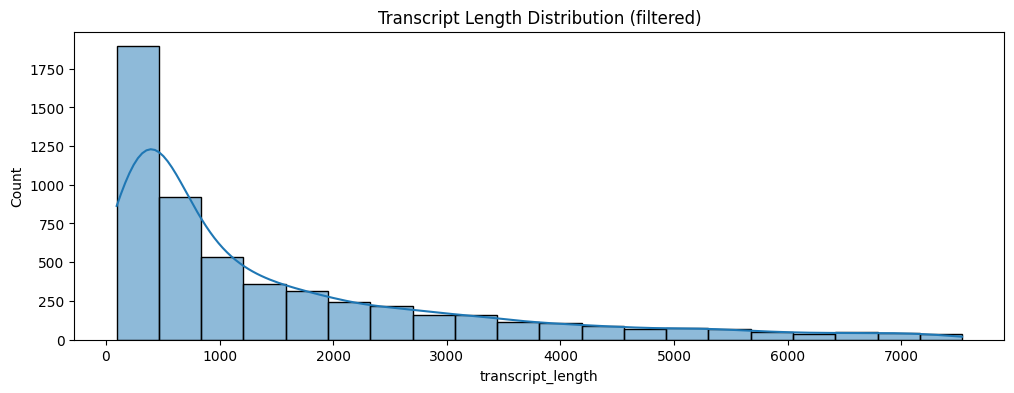

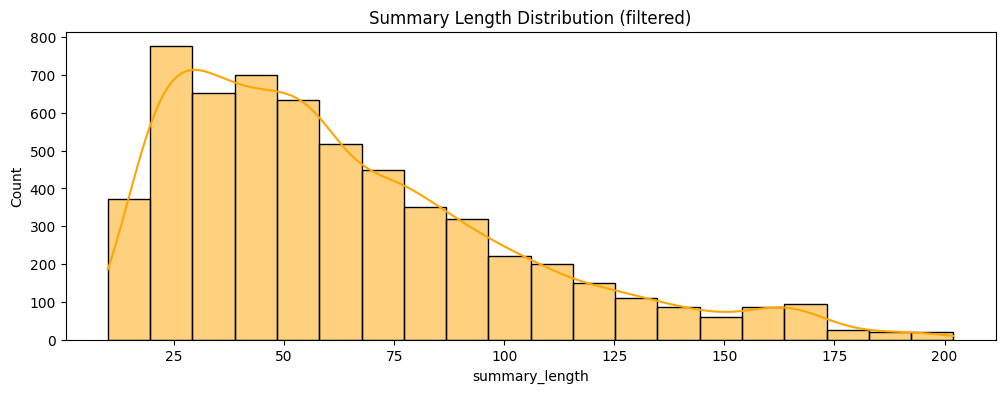

In [11]:
filtered_ds = train_ds[train_ds["transcript_length"] < train_ds["transcript_length"].quantile(0.90)]
filtered_summ = train_ds[train_ds["summary_length"] < train_ds["summary_length"].quantile(0.95)]

plt.figure(figsize=(12,4))
sns.histplot(filtered_ds["transcript_length"], bins=20, kde=True)
plt.title("Transcript Length Distribution (filtered)")
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(filtered_summ["summary_length"], bins=20, kde=True, color="orange")
plt.title("Summary Length Distribution (filtered)")
plt.show()

In [12]:
train_ds["compression_ratio"] = train_ds["summary_length"] / train_ds["transcript_length"]
train_ds["compression_ratio"].describe()

,compression_ratio
count,6149.000000
mean,0.113995
std,0.137460
min,0.000395
25%,0.017409
50%,0.061684
75%,0.161279
max,0.971910


In [13]:
(train_ds == "").sum()
train_ds.isnull().sum()

,0
prompt,0
meeting_transcript,0
summary,0
transcript_length,0
summary_length,0
prompt_length,0
compression_ratio,0


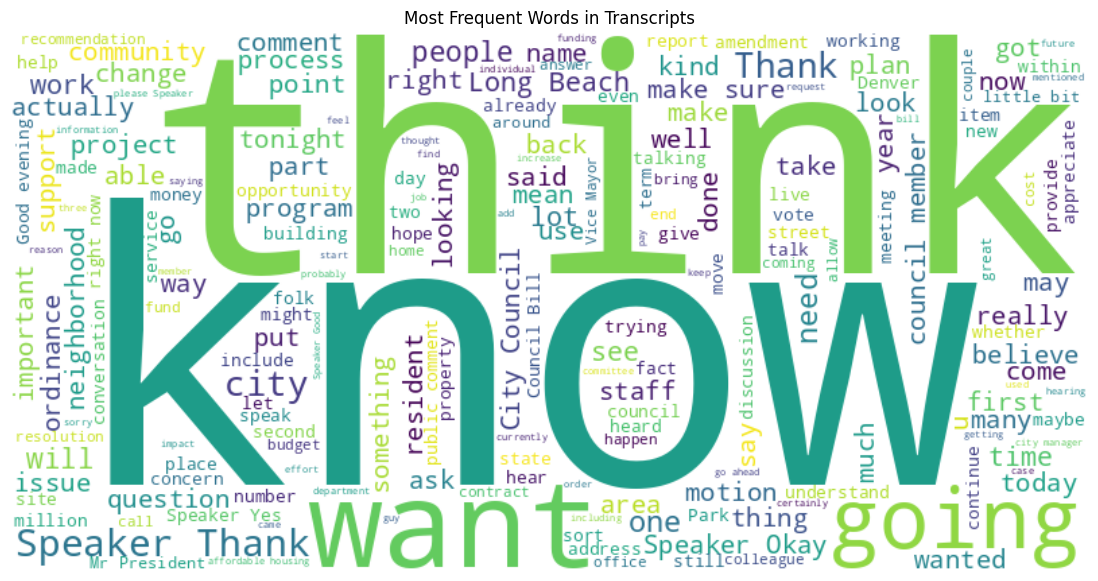

In [14]:
from wordcloud import WordCloud

all_text = " ".join(train_ds["meeting_transcript"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Transcripts")
plt.show()


In [15]:
train_ds["prompt"].value_counts().head(10)

,count
prompt,
Summerize the Whole meeting,5169
What decision was made regarding the renaming of South Street Parkway to Pressburger Parkway?,2
"What revisions to the City Council quasi-judicial proceeding rules were adopted in Resolution 31602, and what was the committee's recommendation?",1
"What agreements were approved regarding Central CHA's use of city facilities, and what are the terms and locations of these agreements?",1
"What are the key outcomes and decisions regarding the approval of the Consolidated Plan for Housing and Community Development programs, including amendments and funding amounts from HUD?",1
What were the key recommendations and outcomes regarding the extension of architectural service contracts and the awarding of contracts for technology and innovation services?,1
"What specific controls are imposed on the Pacific Architect and Builder Building by Ordinance 119182, and what was the outcome of the vote?",1
What actions were taken regarding Resolution 31773 and the appointment of Emily Payne to the Seattle Bicycle Advisory Board?,1
"What are the primary concerns raised by community members regarding the proposed property sale and development project, and what are the city council's responses to these concerns?",1


In [16]:
train_ds.duplicated().sum()
duplicated_rows = train_ds.duplicated(subset=["meeting_transcript", "summary"]).sum()
if duplicated_rows == 0:
  print("Nothing Duplicated")

Nothing Duplicated


<Axes: xlabel='transcript_length', ylabel='summary_length'>

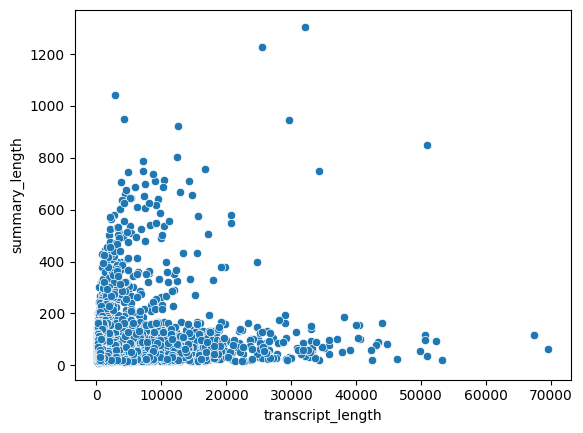

In [17]:
sns.scatterplot(data=train_ds, x="transcript_length", y="summary_length")

In [18]:
train_ds.groupby("prompt")["summary"].nunique().sort_values(ascending=False).head()

,summary
prompt,
Summerize the Whole meeting,4743
What decision was made regarding the renaming of South Street Parkway to Pressburger Parkway?,2
"What strategies are being explored to address the city's unfunded pension and other liabilities, and what is the projected impact of CalPERS' policy changes on future city costs?",1
What technical corrections and fee adjustments were made to Council Bill 119429 regarding the Seattle Animal Shelter and its licensing fees?,1
"What updates and new targets were established in the Seattle commute troop reduction program, and what was the final vote result?",1


In [19]:
!pip install -U spacy

In [31]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tok2vec"])

In [32]:
def get_tokens(text):
  doc = nlp(text)
  return doc

In [33]:
tokens_df = pd.DataFrame()
tokens_df["transcript_tokens"] = train_ds["meeting_transcript"].apply(get_tokens)
tokens_df["summary_tokens"] = train_ds["summary"].apply(get_tokens)

In [36]:
from functools import lru_cache
@lru_cache
def count_tokens(doc):
    return len([token for token in doc if not token.is_space])

train_ds["transcript_token_count"] = tokens_df["transcript_tokens"].apply(count_tokens)
train_ds["summary_token_count"] = tokens_df["summary_tokens"].apply(count_tokens)

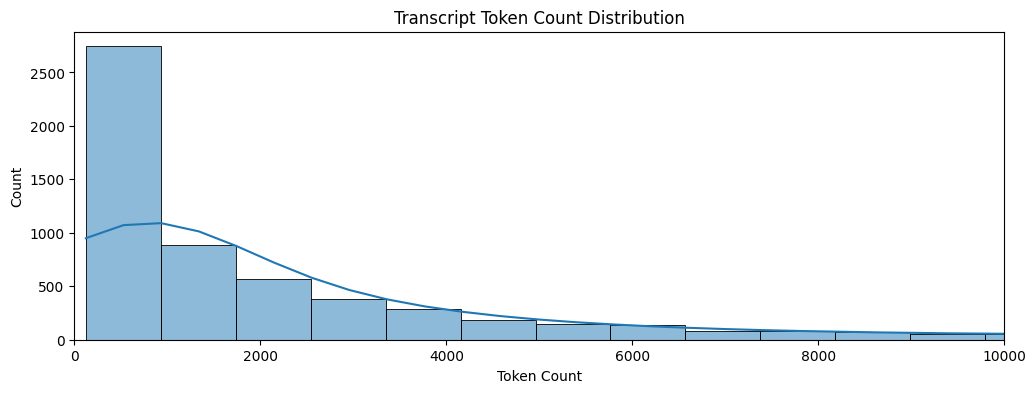

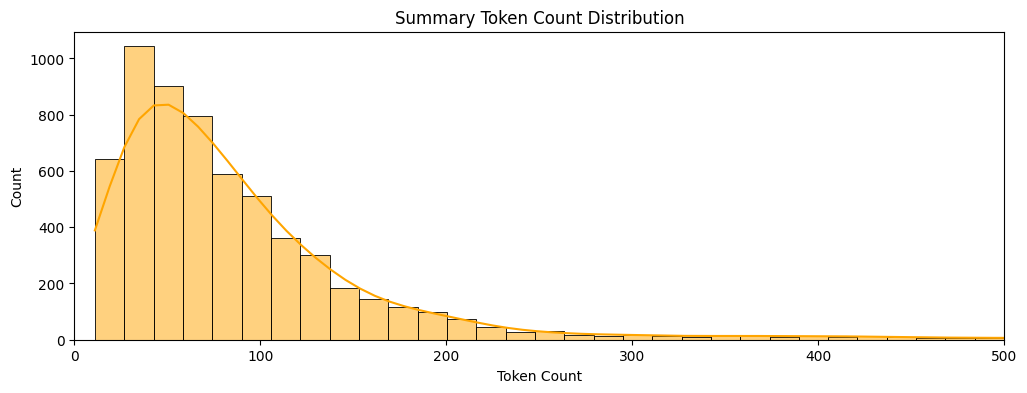

In [37]:
plt.figure(figsize=(12, 4))
sns.histplot(train_ds["transcript_token_count"], bins=100, kde=True)
plt.title("Transcript Token Count Distribution")
plt.xlim(0,10000)
plt.xlabel("Token Count")
plt.show()

plt.figure(figsize=(12, 4))
sns.histplot(train_ds["summary_token_count"], bins=100, kde=True, color="orange")
plt.title("Summary Token Count Distribution")
plt.xlim(0,500)
plt.xlabel("Token Count")
plt.show()

In [38]:
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
from itertools import chain
from functools import lru_cache

@lru_cache
def filter_tokens(doc):
      return [token.lemma_.lower() for token in doc
                if token.is_alpha and token.lemma_.lower() not in STOP_WORDS]

tokens_df["filtered_transcript_tokens"] = tokens_df["transcript_tokens"].apply(filter_tokens)
tokens_df["filtered_summary_tokens"] = tokens_df["summary_tokens"].apply(filter_tokens)

flat_transcript_tokens = chain.from_iterable(tokens_df["filtered_transcript_tokens"])
flat_summary_tokens = chain.from_iterable(tokens_df["filtered_summary_tokens"])

transcript_common = Counter(flat_transcript_tokens).most_common(20)
summary_common = Counter(flat_summary_tokens).most_common(20)


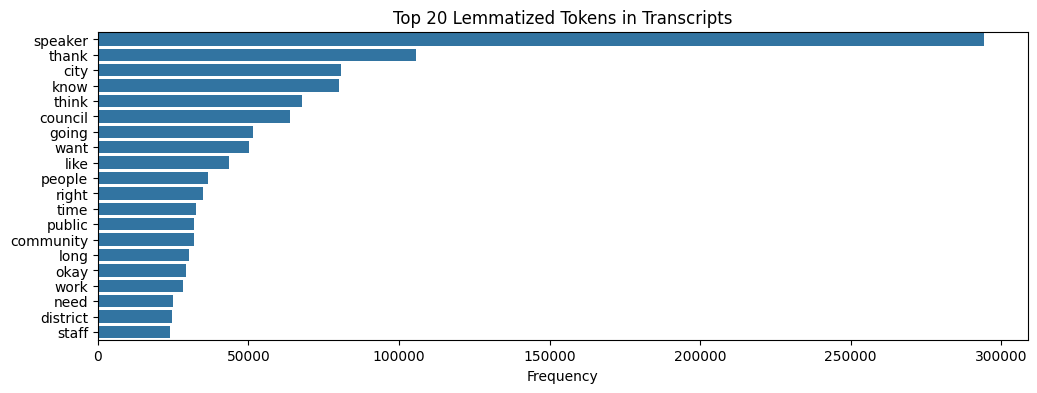

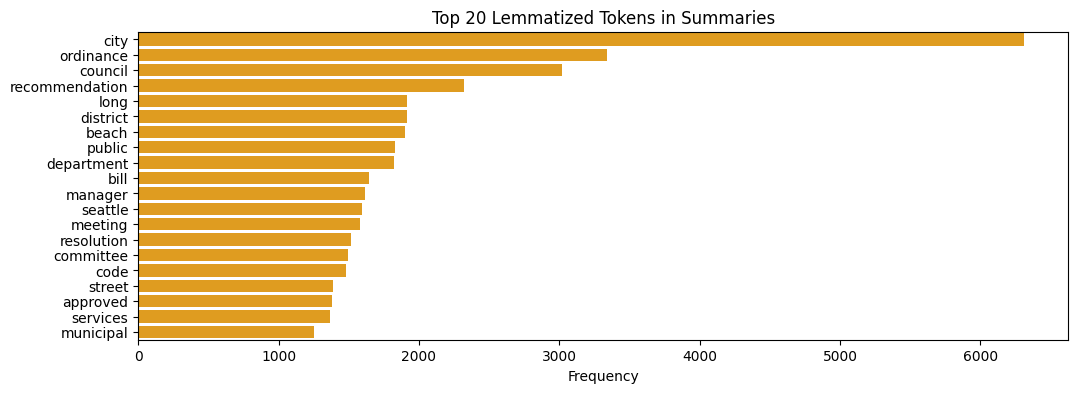

In [39]:
words, freqs = zip(*transcript_common)
plt.figure(figsize=(12, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Lemmatized Tokens in Transcripts")
plt.xlabel("Frequency")
plt.show()

words, freqs = zip(*summary_common)
plt.figure(figsize=(12, 4))
sns.barplot(x=list(freqs), y=list(words), color='orange')
plt.title("Top 20 Lemmatized Tokens in Summaries")
plt.xlabel("Frequency")
plt.show()


# Preprocessing Phase

In [40]:
from nltk.corpus import stopwords
import re
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [41]:
train_ds["meeting_transcript"] = train_ds["meeting_transcript"].apply(clean_text)
train_ds["summary"] = train_ds["summary"].apply(clean_text)
train_ds["prompt"] = train_ds["prompt"].apply(clean_text)

In [42]:
train_ds.head()

,prompt,meeting_transcript,summary,transcript_length,summary_length,prompt_length,compression_ratio,transcript_token_count,summary_token_count
0,what are the key details of the proposal to tr...,"speaker 0: okay. item 17, please. speaker 1: c...",the proposal involves transferring one-time di...,928,89,36,0.095905,1108,101
1,what specific actions and recommendations are ...,speaker 0: the motion is here. speaker 1: than...,"based on the meeting transcript, here's a summ...",5610,304,32,0.054189,6389,403
2,what specific monitoring and reporting measure...,speaker 2: the report of the seattle public ut...,here's a summary addressing the prompt: **moni...,2440,168,30,0.068852,2778,217
3,what was the outcome of the recommendation to ...,speaker 0: item number 34. could you please be...,the recommendation to execute documents with d...,180,55,31,0.305556,238,69
4,what conditions were placed on the entertainme...,speaker 0: thank you. we have a motion in a se...,the entertainment permit for st. anita's resta...,526,49,18,0.093156,620,63
